In [2]:
########################################################################
# import default libraries
########################################################################
import os
import sys
import gc
########################################################################


########################################################################
# import additional libraries
########################################################################
import numpy as np
import scipy.stats
# from import
from tqdm import tqdm
try:
    from sklearn.externals import joblib
except:
    import joblib
# original lib
import common as com
import keras_model
import pandas as pd
import keras
import librosa
import tensorflow as tf
import librosa.display
############
########################################################################
# load parameter.yaml
########################################################################
param = com.yaml_load()

In [3]:
# def spec_augment_freq(spec: np.ndarray, num_mask=1, freq_masking_max_percentage=0.9):
#     spec = spec.copy()
#     spec[43:60, :] = np.min(spec)
#     spec[60:79, :] = np.min(spec)
#     return spec

def spec_augment_freq(spec: np.ndarray, num_mask=1, freq_masking_max_percentage=0.9):
    spec = spec.copy()
    spec[23:43, :] = 0
    return spec

def spec_augment(spec: np.ndarray, num_mask=2, freq_masking_max_percentage=0.2):
    spec2 = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec2.shape
        freq_percentage = freq_masking_max_percentage
        num_frames_to_mask = int(freq_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=(all_frames_num) - num_frames_to_mask)
        t0 = int(t0)
        spec2[t0:t0 + num_frames_to_mask, :] = 0
        # np.min(spec)
    return spec2

In [5]:
target_dir = "D:/B4/u-net/dev_data/car8"
mode = True
dirs = com.select_dirs(param=param, mode=mode)

# loop of the base directory
idx=0
print("\n===========================")
print("[{idx}/{total}] {target_dir}".format(target_dir=target_dir, idx=idx+1, total=len(dirs)))
machine_type = os.path.split(target_dir)[1]


def load_model(file_path):
    return keras.models.load_model(file_path, compile=False)

  
print("============== MODEL LOAD ==============")
# load model file
model_file = "{model}/model_{machine_type}.hdf5".format(model=param["model_directory"],
                                                        machine_type=machine_type)
if not os.path.exists(model_file):
    com.logger.error("{} model not found ".format(machine_type))
    sys.exit(-1)
model = load_model(model_file)
model.summary()



2022-10-12 06:50:12,824 - INFO - load_directory <- development



[1/8] D:/B4/u-net/dev_data/car8
============== MODEL LOAD ==============
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 block_1_conv (Conv2D)          (None, 512, 128, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block_1_conv_bn (BatchNormaliz  (None, 512, 128, 16  64         ['block_1_conv[0][0]']           
 ation)           

In [16]:
print("\n============== BEGIN TEST FOR A SECTION ==============")
y_pred = [0. for k in range(20)]
y_pred_freq = [0. for k in range(20)]
y_pred_time = [0. for k in range(20)]
file_idx=1
# file_path='/content/drive/MyDrive/dev_data/car8/source_test/section_07_source_test_anomaly_0000 (126).wav'
file_path='D:/B4/u-net/dev_data/car1/source_test/section_00_source_test_anomaly_0000 (64).wav'
# file_path='D:/B4/u-net/dev_data/car1/source_test/section_00_source_test_normal_0000 (4).wav'
file_path='D:/B4/u-net/dev_data/car1/source_test/section_00_source_test_normal_0000 (52).wav'
vectors = com.file_to_vectors(file_path,
                              n_mels=128,
                              n_frames=1,
                              n_fft=1024,
                              hop_length=431,
                              power=2)
vectors = librosa.power_to_db(vectors)
vectors_masked = spec_augment(vectors)
data = np.zeros((1, vectors.shape[1], vectors.shape[0]),float)
data_masked = np.zeros((1, vectors_masked.shape[1], vectors_masked.shape[0]), float)
data[0, :, :] = vectors.T
data_masked[0, :, :] = vectors_masked.T
data = data[:, :, :, np.newaxis]
data_masked = data_masked[:, :, :, np.newaxis]



print(data[0,:,:].shape)


============== BEGIN TEST FOR A SECTION ==============
(512, 128, 1)


In [17]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 26ms/step


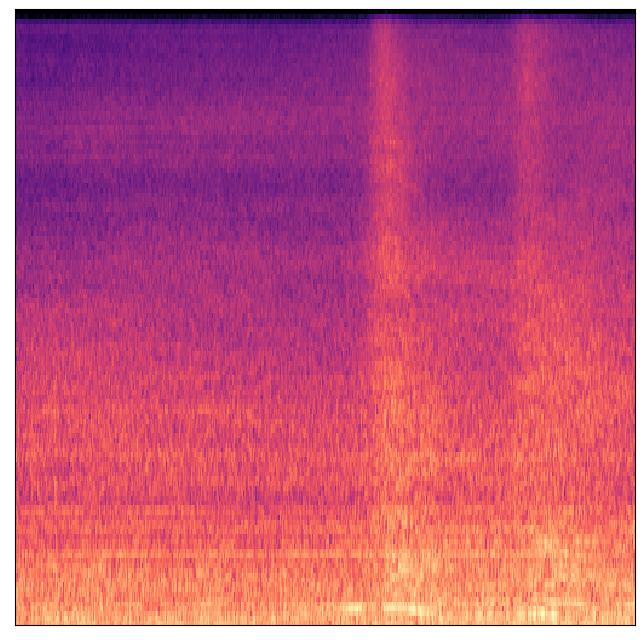

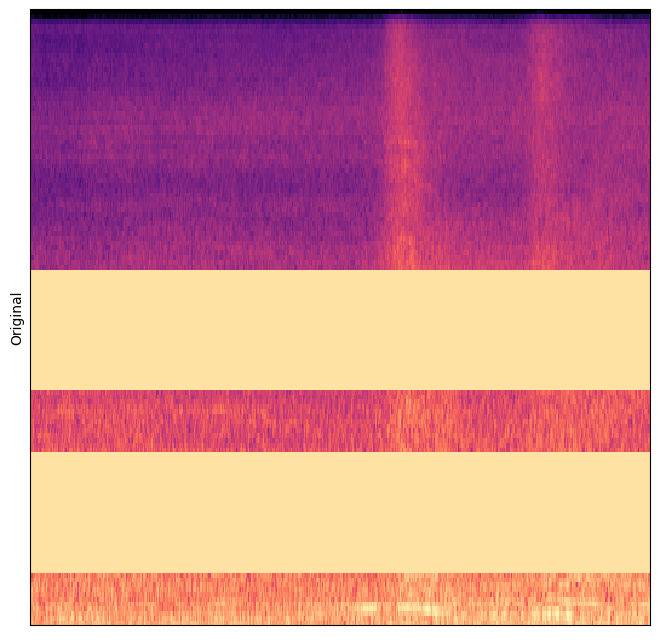

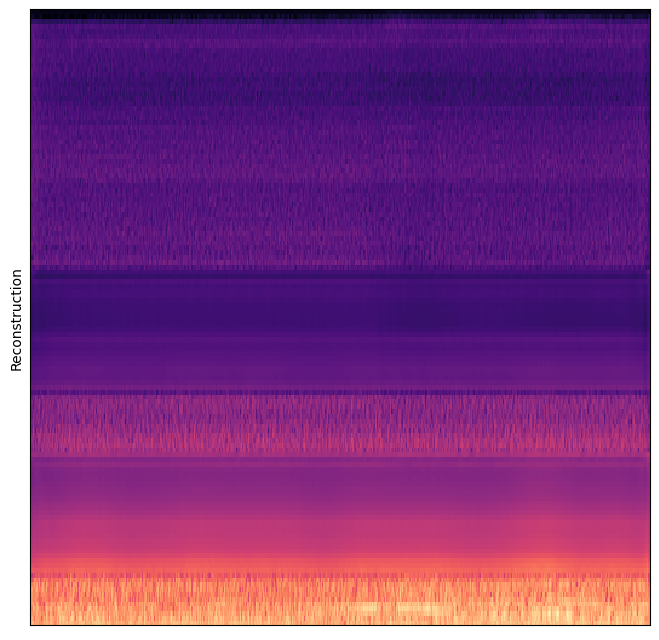

329.6113804601148


In [18]:
reconstruction = model.predict(data_masked)
# y_pred = np.mean(np.square((data[0,:,46:76] - reconstruction[0,:,46:76])))
y_pred = np.mean(np.square((data[0,:,23:43] - reconstruction[0,:,23:43])))

plt.gcf().set_size_inches(8, 8)
plt.subplot()
librosa.display.specshow(np.squeeze(data, axis=3)[0,:,:].T, cmap='magma')
plt.show()

plt.subplot()
plt.gcf().set_size_inches(8, 8)

librosa.display.specshow(np.squeeze(data_masked, axis=3)[0,:,:].T, cmap='magma')
plt.ylabel("Original")
plt.show()
plt.subplot()
plt.gcf().set_size_inches(8, 8)

librosa.display.specshow(np.squeeze(reconstruction, axis=3)[0,:,:].T[:,:], cmap='magma')
plt.ylabel("Reconstruction")
# plt.subplot(3,1,3)
# y_ano = []
# y_nor = []
# x_ano = []
# x_nor = []
# n=-1
# for k in y_pred_time:
#     n+=1
#     if k > 13.3:
#         x_ano.append(n)
#         y_ano.append(1)
# n=-1
# for k in y_pred_time:
#     n+=1
#     if k < 13.3:
#         x_nor.append(n)
#         y_nor.append(0)
# x_ano = [x*5*3*512/16000 for x in x_ano]
# x_nor = [x*5*3*512/16000 for x in x_nor]
# x_nor[-1] = 10
# x_nor[0] = x_ano[-1]
# plt.plot(x_ano, y_ano, '-',color='r')
# plt.plot(x_nor, y_nor, '-',color='b')
# plt.fill_between(x_ano, y_ano,-2, alpha= 0.2, label='Anomaly', color='r')
# plt.ylim(0, 2)
# plt.xlim(0, 10)
# plt.xticks([])
# plt.yticks([])
# plt.legend(fontsize=8.5)
# plt.subplot(4,1,4)
# plt.plot(x, y_pred_time)
# plt.plot(x, y, '--',color='r')
# plt.ylim(0, max(y_pred_time)+10)
# plt.xlim(0, 10)
# plt.xlabel("Time (s)")
# plt.ylabel("Anomaly Score")
# plt.subplots_adjust(hspace=.0)
# plt.fill_between(x, y_pred_time, y, alpha= 0.2, where = (np.array(y_pred_time) > 12.5), label='Anomaly', color='r')
# plt.plot([], [], ' ', label="Mean Anomaly Score={:.2f}".format(anomaly_score_list[1][1]))
# plt.legend(fontsize=6.5)
plt.show()
print(y_pred)


